<a href="https://colab.research.google.com/github/kazars24/tinkoff-dl-fall22/blob/main/CNN%20%2B%20Residual/seminar_FrXFbmU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolution neural networks practice

In [3]:
import sys

import torch
from torch.nn import functional
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable, NamedTuple, List
from collections import namedtuple


plt.style.use('dark_background')

'''
if sys.version_info.minor < 8:
    print(f"torchvision.__version__={torch.__version__}")
    print(f"torch.__version__={torchvision.__version__}")
else:
    print(f"{torch.__version__=}")
    print(f"{torchvision.__version__=}")
'''

'\nif sys.version_info.minor < 8:\n    print(f"torchvision.__version__={torch.__version__}")\n    print(f"torch.__version__={torchvision.__version__}")\nelse:\n    print(f"{torch.__version__=}")\n    print(f"{torchvision.__version__=}")\n'

### Convolution Layer

In [ ]:
# help(torch.nn.Conv2d)

![convolution](misc/no_padding_no_strides.gif)

In [4]:
batch_size, channel_size, height, width = (1, 1, 16, 16)
out_channels, kernel_size, padding, stride = (4, 3, 0, 1)
example_input: torch.Tensor = torch.randn(batch_size, channel_size, height, width)

convolution: torch.nn.Module = torch.nn.Conv2d(
    in_channels=channel_size,
    out_channels=out_channels,
    kernel_size=kernel_size,
    padding=padding,
    stride=stride
)
print(f"Convolution, # of params")
print(f"Weight: {convolution.weight.numel()}")
print(f"Bias: {convolution.bias.numel()}")

output: torch.Tensor = convolution(example_input)

print(f"Output shape: {output.shape}")

Convolution, # of params
Weight: 36
Bias: 4
Output shape: torch.Size([1, 4, 14, 14])


Learnable parameters are objects of a class `torch.nn.Parameter`

To access parameters directly, a method `data` must be called

In [5]:
print(
    f"weight and bias types are: "
    f"{type(convolution.weight)}, {type(convolution.bias)}"
)
print(
    f"weight.data and bias.data types are:"
    f" {type(convolution.weight.data)}, {type(convolution.bias.data)}"
)
print(
    f"Corresponding shapes are:"
    f"{convolution.weight.data.shape} and {convolution.bias.data.shape}"
)

weight and bias types are: <class 'torch.nn.parameter.Parameter'>, <class 'torch.nn.parameter.Parameter'>
weight.data and bias.data types are: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Corresponding shapes are:torch.Size([4, 1, 3, 3]) and torch.Size([4])


Another way to convolve tensor with a kernel is to use functional style:

In [6]:
example_kernel: torch.Tensor = torch.randn(out_channels, channel_size, kernel_size, kernel_size)
example_bias: torch.Tensor = torch.randn(out_channels)

# in order to optimize weights through gradient descent, you need to turn on gradient evaluation
# example_kernel.requires_grad_()
# example_bias.requires_grad_()
print(
    f"Gradients are required (parameters): "
    f"{example_kernel.requires_grad}, {example_bias.requires_grad}"
)
print(f"Gradients are required (input): {example_input.requires_grad}")

output: torch.Tensor = functional.conv2d(
    example_input,
    example_kernel,
    bias=example_bias,
    padding=padding,
    stride=stride
)

print(f"Output shape: {output.shape}")

Gradients are required (parameters): False, False
Gradients are required (input): False
Output shape: torch.Size([1, 4, 14, 14])


Let's compare two ways of calculations, to make sure that results are the same

In [7]:
kernel = convolution.weight.data.detach().clone()
bias = convolution.bias.data.detach().clone()

output1 = convolution(example_input)
output2 = functional.conv2d(
    example_input,
    kernel,
    bias=bias,
    padding=padding,
    stride=stride
)

assert torch.allclose(output1, output2, atol=1e-7), "Results aren't the same"

#### Padding

![padding](misc/convolution.gif)

In [8]:
batch_size, channel_size, height, width = (1, 1, 16, 16)
out_channels, kernel_size, padding, stride = (4, 3, 1, 1)
example_input: torch.Tensor = torch.randn(batch_size, channel_size, height, width)

convolution: torch.nn.Module = torch.nn.Conv2d(
    in_channels=channel_size,
    out_channels=out_channels,
    kernel_size=kernel_size,
    padding=padding,
    stride=stride
)

output: torch.Tensor = convolution(example_input)
print(f"Input shape: {example_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 1, 16, 16])
Output shape: torch.Size([1, 4, 16, 16])


#### Strides

![strides](misc/no_padding_strides.gif)

In [9]:
batch_size, channel_size, height, width = (1, 1, 16, 16)
out_channels, kernel_size, padding, stride = (4, 3, 1, 2)
example_input: torch.Tensor = torch.randn(batch_size, channel_size, height, width)

convolution: torch.nn.Module = torch.nn.Conv2d(
    in_channels=channel_size,
    out_channels=out_channels,
    kernel_size=kernel_size,
    padding=padding,
    stride=stride
)

output: torch.Tensor = convolution(example_input)
print(f"Input shape: {example_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 1, 16, 16])
Output shape: torch.Size([1, 4, 8, 8])


Strides and paddings don't have to be same on each side. For example:

In [10]:
padding = (1, 0)
stride = (2, 1)

convolution: torch.nn.Module = torch.nn.Conv2d(
    in_channels=channel_size,
    out_channels=out_channels,
    kernel_size=kernel_size,
    padding=padding,
    stride=stride
)

output: torch.Tensor = convolution(example_input)
print(f"Input shape: {example_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 1, 16, 16])
Output shape: torch.Size([1, 4, 8, 14])


#### Dilated convolution

![dilated](misc/dilated_convolution.gif)

In [11]:
example_input = torch.tensor([[[[i + 1 for i in range(7)] for _ in range(7)]]]).float()

print(example_input)

tensor([[[[1., 2., 3., 4., 5., 6., 7.],
          [1., 2., 3., 4., 5., 6., 7.],
          [1., 2., 3., 4., 5., 6., 7.],
          [1., 2., 3., 4., 5., 6., 7.],
          [1., 2., 3., 4., 5., 6., 7.],
          [1., 2., 3., 4., 5., 6., 7.],
          [1., 2., 3., 4., 5., 6., 7.]]]])


In [12]:
dilated_convolution: torch.nn.Module = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    padding=0,
    stride=1,
    dilation=2,
    bias=False
)

dilated_convolution.weight.data = torch.ones(1, 1, 3, 3)

print(dilated_convolution(example_input).detach())

tensor([[[[27., 36., 45.],
          [27., 36., 45.],
          [27., 36., 45.]]]])


---

### Pooling

![pooling](misc/pooling.gif)

There are 2 main types of pooling
- Adaptive Pooling
- Max Pooling

In [13]:
example_input = torch.tensor([[[[1,2,3], [1,2,3], [1, 2, 3]]]]).float()

print(example_input)

tensor([[[[1., 2., 3.],
          [1., 2., 3.],
          [1., 2., 3.]]]])


In [14]:
pooling = torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
# or functional style
# functional.avg_pool2d()

print(pooling(example_input))

tensor([[[[1.5000, 2.5000],
          [1.5000, 2.5000]]]])


In [15]:
pooling = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
# or functional style
# functional.max_pool2d()

print(pooling(example_input))

tensor([[[[2., 3.],
          [2., 3.]]]])


---

### Activation functions

#### Sigmoid

$\sigma(x) = \frac{1}{1 + e^{-x}}$

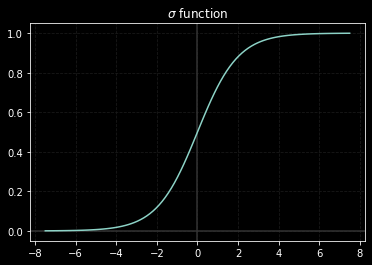

In [16]:
def plot_activation(
    func_name: str,
    activation: Callable[[float], float]
):
    
    plt.axhline(c='.2')
    plt.axvline(color='.2')
    plt.grid(c='.1', ls='--')

    
    z = torch.linspace(-7.5, 7.5, 100)
    plt.plot(z, activation(z))
    plt.title(func_name)
    plt.show()

plot_activation("$\sigma$ function", torch.sigmoid)

#### SoftPlus

$Softplus(x) = \frac{1}{\beta}log(1 + e^{\beta * x})$

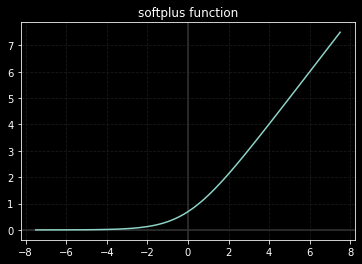

In [17]:
plot_activation("softplus function", torch.nn.Softplus())

#### ReLU

$R(x) = max(0, x)$

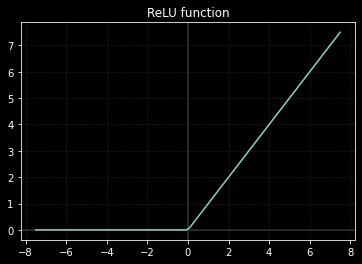

In [18]:
plot_activation("ReLU function", torch.nn.ReLU())

#### Sigmoid Linear Unit

$silu(x) = x * \sigma(x)$


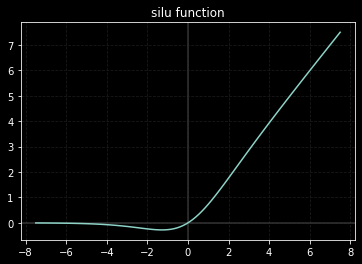

In [19]:
plot_activation("silu function", torch.nn.SiLU())

#### Mish

$Mish(x)=x*Tanh(Softplus(x))$

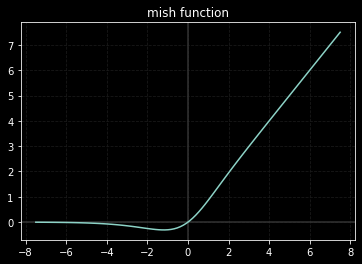

In [20]:
plot_activation("mish function", torch.nn.Mish())

There are many more activation functions. You can check them out, for example, there: [link](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)


---

## Residual connections
### ResNets
[paper](https://arxiv.org/pdf/1512.03385.pdf)

![residual](misc/residual.png)

In [21]:
class BasicBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int
    ):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1
        )
        self.conv2 = torch.nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1
        )
        self.relu = torch.nn.ReLU(inplace=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out


class ResidualBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int
    ):
        super().__init__()
        self.basic = BasicBlock(in_channels, out_channels)
        if in_channels != out_channels:
            self.downsample = torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1
            )
        else:
            self.downsample = None
        self.relu = torch.nn.ReLU(inplace=True)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.basic(x)
        
        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

You can see implementation [here](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)

In [22]:
example_input = torch.randn(1, 3, 256, 256)
block = ResidualBlock(3, 16)

output = block(example_input)

print(f"Input shape: {example_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 16, 256, 256])


---

## Training MNIST

In [24]:
# Chose appropriate device: "cpu", "cuda" or "mps"

device: torch.device

if torch.cuda.is_available():
    device = torch.device("cuda")
elif int(torch.__version__.split(".")[1]) >= 12 and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
'''
if sys.version_info.minor < 8:
    print(f"device={device}")
else:
    print(f"{device=}")
'''

'\nif sys.version_info.minor < 8:\n    print(f"device={device}")\nelse:\n    print(f"{device=}")\n'

**Data visualization**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data/
    Split: Train
# of examples: 60000


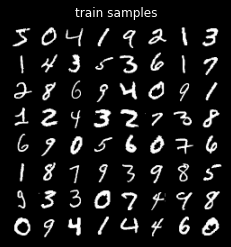

In [25]:
dataset = torchvision.datasets.MNIST(".data/", train=True, download=True)

print(dataset)
print(f"# of examples: {len(dataset)}")

x = torch.cat([
    torch.from_numpy(np.array(dataset[idx][0]))[None][None]
    for idx in range(64)
])

plt.imshow(torchvision.utils.make_grid(x).permute(1,2,0))
plt.title("train samples")
plt.axis("off")
plt.show()

**Define datasets**

In [26]:
transform=torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307), (0.3081))
    ]
)

batch_size = 128

train_dataset = torchvision.datasets.MNIST(".data/", train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(".data/", train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Define Model**

In [27]:
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 7),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3),
            torch.nn.ReLU(),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            torch.nn.MaxPool2d(2)
        )
        self.clf = torch.nn.Linear(7 * 7 * 64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature_map = self.extractor(x)
        feature_vector = torch.flatten(feature_map, 1)
        return self.clf(feature_vector)

**Training/Evaluation functions**

In [28]:
def train_epoch(
    model: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, 
    loader: torch.utils.data.DataLoader, 
    criterion: torch.nn.modules.loss._Loss,
    device: torch.device,
    verbose: bool = False,
) -> float:
    model.train(True)
    model.to(device)
    optimizer.zero_grad()
    acc_loss = 0
    total = len(loader.dataset)
    if verbose:
        loader = tqdm(loader, desc="Training", total=len(loader), leave=True)
    for input_data, target in loader:
        input_data = input_data.to(device)
        target = target.to(device)
        predicted = model(input_data)
        
        loss = criterion(predicted, target)
        
        # calculate gradient
        loss.backward()
        # update weights
        optimizer.step()
        # flush gradients
        optimizer.zero_grad()
        acc_loss += loss.item()
        
    return acc_loss / total


EvalOutput = namedtuple("EvalOutput", ["loss", "accuracy"])


def eval_epoch(
    model: torch.nn.Module, 
    loader: torch.utils.data.DataLoader, 
    criterion: torch.nn.modules.loss._Loss,
    device: torch.device,
    verbose: bool = False,
) -> EvalOutput:
    model.train(False)
    model.to(device)
    acc_loss = 0
    acc = 0
    total = len(loader.dataset)

    # no grad for context manager to accelerate evaluation
    with torch.no_grad():
        if verbose:
            loader = tqdm(loader, desc="Evaluation", total=len(loader), leave=True)
        for input_data, target in loader:
            input_data = input_data.to(device)
            target = target.to(device)
            predicted = model(input_data)
            
            loss = criterion(predicted, target)
            acc_loss += loss.item()

            acc += torch.sum(
                torch.argmax(predicted, 1) == target
            ).item()

    return EvalOutput(
        loss=acc_loss / total,
        accuracy=acc / total
    )


class TrainOutput(NamedTuple):
    train_loss: List[float]
    val_loss: List[float]
    val_accuracy: List[float]


def train(
    num_epochs: int,
    model: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, 
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.modules.loss._Loss,
    device: torch.device
) -> TrainOutput:

    train_loss = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        loss = train_epoch(
            model, optimizer, train_loader, criterion, device, verbose=True
        )
        train_loss.append(loss)
        eval_out = eval_epoch(
            model, test_loader, criterion, device, verbose=True
        )
        val_loss.append(eval_out.loss)
        val_acc.append(eval_out.accuracy)

        print(f"Epoch #{epoch}:")
        print(f"Training Loss: {loss}")
        print(f"Evaluation Loss: {eval_out.loss}")
        print(f"Accuracy: {eval_out.accuracy}")
    return TrainOutput(
        train_loss=train_loss,
        val_loss=val_loss,
        val_accuracy=val_acc
    )

**Create model, chose optimizer & criterion**

In [29]:
model = ConvNet(len(train_dataset.classes))

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()
model.to(device);

---

**Train & visualize results**

In [30]:
num_epochs = 5

training_results = train(
    num_epochs,
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
    criterion,
    device
)

Evaluation: 100%|██████████| 79/79 [00:01<00:00, 42.23it/s]


Epoch #0:
Training Loss: 0.0027949480432396135
Evaluation Loss: 0.0005771608589799144
Accuracy: 0.9778


Evaluation: 100%|██████████| 79/79 [00:01<00:00, 40.41it/s]


Epoch #1:
Training Loss: 0.0005979601620851705
Evaluation Loss: 0.0004522112283390015
Accuracy: 0.9817


Evaluation: 100%|██████████| 79/79 [00:01<00:00, 42.07it/s]


Epoch #2:
Training Loss: 0.0004251335367637997
Evaluation Loss: 0.0003232317653571954
Accuracy: 0.9867


Evaluation: 100%|██████████| 79/79 [00:01<00:00, 40.58it/s]


Epoch #3:
Training Loss: 0.00033631985041623316
Evaluation Loss: 0.00026288493583269884
Accuracy: 0.9889


Evaluation: 100%|██████████| 79/79 [00:01<00:00, 41.16it/s]

Epoch #4:
Training Loss: 0.00027576613531176314
Evaluation Loss: 0.00024688968162663515
Accuracy: 0.9892


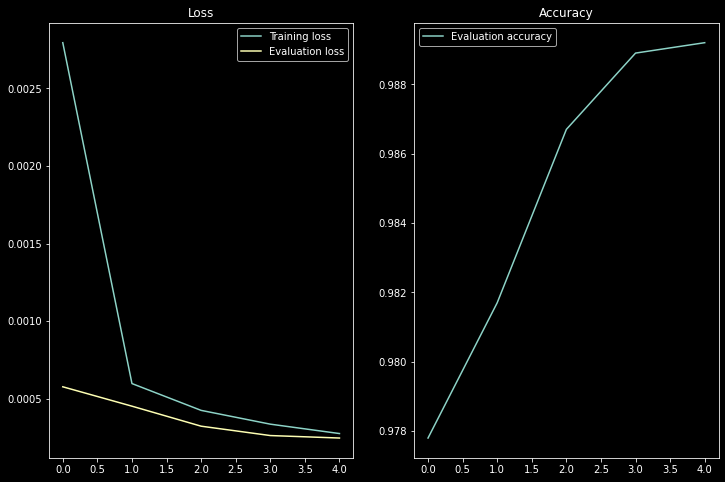

In [31]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))
ax = ax.flatten()

ax[0].plot(
    np.arange(len(training_results.train_loss)),
    training_results.train_loss,
    label="Training loss"
)
ax[0].plot(
    np.arange(len(training_results.val_loss)),
    training_results.val_loss,
    label="Evaluation loss"
)
ax[1].plot(
    np.arange(len(training_results.val_accuracy)),
    training_results.val_accuracy,
    label="Evaluation accuracy"
)
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")

plt.show()

---

**Save & Load model to check everything is ok**

In [32]:
# save model state dict and load it back
ckpt = "checkpoint.pt"
cpu_device = torch.device("cpu")
model.to(cpu_device).eval()

# saving
torch.save(model.state_dict(), ckpt)

# loading
state_dict = torch.load(ckpt, cpu_device)
loaded_model = ConvNet(10)
loaded_model.load_state_dict(state_dict)
loaded_model.to(cpu_device).eval()

# check, results are the same
example_input = torch.randn(256, 1, 28, 28)
with torch.no_grad():
    out1 = model(example_input)
    out2 = loaded_model(example_input)
    assert torch.allclose(out1, out2)

**JIT**

[TorchScript](https://pytorch.org/docs/stable/jit.html)

In [33]:
ckpt = "traced.pt"

# saving
traced = torch.jit.trace(model, example_input)
torch.jit.save(traced, ckpt)

# loading
loaded_model = torch.jit.load(ckpt)

# check, results are the same
example_input = torch.randn(256, 1, 28, 28)
with torch.no_grad():
    out1 = model(example_input)
    out2 = loaded_model(example_input)
    assert torch.allclose(out1, out2)

---